# General

The flow of a Geospatial APIs query can take one of three paths:-

- in the case of an `interactive` query (point) data is returned synchronously as a result of the `submit` request,


![interactive](images/interactive.png)



- in the case of a `batch` query (raster, batch point); the flow is to `submit`, check the `status` then `download` the result, 

- when an interactive query is large, the query is converted to batch and returned with the `submit`, check `status` and then `download` flow.

![batch](images/batch.png)

The recommended way to ensure the SDK handles the query regardless of the situation is to use the combined helper function `ibmpairs.query.submit_check_status_and_download()`, however to explain the flows in more detail the following paragraphs will provide a run down of the individual steps.

## Submit

The `submit()` method of the `ibmpairs.query.Query` object executes a __POST__ request to the __/query__ endpoint. 

The result of the request is retained in the `ibmpairs.query.Query` object's structure in the attribute `submit_response`.

Any function or `ibmpairs.query.Query` method with a submit (e.g. `ibmpairs.query.submit_check_status_and_download()`) takes as an input a dict or string representation of a query, e.g.

```python
query_dict = {
    "name": "ESA Sentinel 2 Band 4 Red",
    "layers": [
        {
            "id": 49360,
            "type": "raster"
        }
    ],
    "spatial": {
        "type": "square",
        "coordinates": [
            31.01972738,
            -104.86979442,
            31.05847466,
            -104.8188164
        ]
    },
    "temporal": {
        "intervals": [
            {
                "start": "2023-02-26T00:00:00",
                "end": "2023-02-28T00:00:00"
            }
        ]
    }
}

query_result = query.submit_check_status_and_download(query_dict)
```

## Status

The `status()` method of the `ibmpairs.query.Query` object executes a set of polling __GET__ requests to the __/queryjobs/{id}__ endpoint on an interval, where the __{id}__ is the id returned by the `submit()` method and stored in the `id` attribute. The method continues to poll until a final status is received, either success (20) or failure (any status number > 20).


|ID|Status|
|--|------|
|0 |Queued|
|1 |Initializing|
|10|Running|
|11|Writing|
|12|Packaging|
|20|Succeeded|
|21|NoDataFound|
|30|Killed|
|31|Deleted|
|40|Failed|
|41|FailedConversion|
|42|FailedProcessor|
|43|MaxAllowedQuerySizeExceeded|


The aforementioned interval can be specified by use of the environment variable `QUERY_STATUS_CHECK_INTERVAL` configured as seconds (default 30). There is a lower threshold boundary of 15 seconds.

## Download

The `download()` method of the `ibmpairs.query.Query` object executes a __GET__ request to the __/queryjobs/{id}/download__ endpoint, where the __{id}__ is the id returned by the `submit()` method and stored in the `id` attribute. 

The data will be downloaded to the relative path __./download/__ by default, there are options to alter this behaviour by setting the `download_folder` attribute or supplying an equivalently named parameter to the `download()` method.

The `download()` method first checks that the user submitted query has completed by calling on the `status()` method, if the query is incomplete the `status()` method will poll for a final status.

If the download method is called on an interactive query, the data from the `submit_response` attribute will be saved to a file with the filename (preference order): 

- the query `name` attribute supplied in the query json (if specified),
- the format `point_query_YYYYMMDD-HHmmss.json`

## Load

To load the query result data into a framework in which it can be manipulated, the following methods, for point queries and raster queries, can be used:

In [ ]:
%pip install ibmpairs
%pip install configparser

In [1]:
import os
import ibmpairs.query as query
import ibmpairs.client as client

import configparser

config = configparser.RawConfigParser()
config.read('../../../auth/secrets.ini')
# Best practice is not to include secrets in source code so we read
# an api key, tenant id and org id from a secrets.ini file.
# You could set the credentials in-line here but we don't
# recommend it for security reasons.

EI_API_KEY    = config.get('EI', 'api.api_key')
EI_TENANT_ID  = config.get('EI', 'api.tenant_id') 
EI_ORG_ID     = config.get('EI', 'api.org_id') 

ei_client = client.get_client(api_key   = EI_API_KEY,
                              tenant_id = EI_TENANT_ID,
                              org_id    = EI_ORG_ID)

point_query_json = {
  "name": "IBM Lowell",
  "layers": [
    {
      "type": "raster",
      "id": "49423"
    }
  ],
  "spatial": {
    "type": "point",
    "coordinates": [
      "42.614760",
      "-71.325230"
    ]
  },
  "temporal": {
    "intervals": [
      {
        "start": "2024-06-01T00:00:00Z",
        "end": "2024-06-30T00:00:00Z"
      }
    ]
  }
}

point = query.submit_check_status_and_download(point_query_json)

raster_query_json = {
  "name": "Massachusetts",
  "layers": [
    {
      "id": "49423",
      "type": "raster"
    }
  ],
  "spatial": {
    "aoi": 142,
    "type": "poly"
  },
  "temporal": {
    "intervals": [
      {
        "start": "2024-06-01T00:00:00Z",
        "end": "2024-06-01T00:00:00Z"
      }
    ]
  }
}

raster = query.submit_check_status_and_download(raster_query_json)

2024-07-31 17:06:54 - paw - INFO - The client authentication method is assumed to be OAuth2.
2024-07-31 17:06:54 - paw - INFO - Legacy Environment is False
2024-07-31 17:06:54 - paw - INFO - The authentication api key type is assumed to be IBM Cloud IAM, because the api key prefix 'PHX' is not present.
2024-07-31 17:06:55 - paw - INFO - Authentication success.
2024-07-31 17:06:55 - paw - INFO - HOST: https://api.ibm.com/geospatial/run/na/core/v3
2024-07-31 17:06:55 - paw - INFO - TASK: submit_check_status_and_download STARTING.
2024-07-31 17:07:56 - paw - INFO - A real time point query is returned at the time of executing the Query.submit() method. The status is therefore complete. Skipping.
2024-07-31 17:07:56 - paw - INFO - The query download folder is set to the path /ibmpairs/download/.
2024-07-31 17:07:56 - paw - INFO - The online point query output was successfully saved to /ibmpairs/download/IBM Lowell.json.
2024-07-31 17:07:56 - paw - INFO - TASK: submit_check_status_and_downlo

### Point query

If the data is a point query, there is a helper method `point_data_as_dataframe()` in the `ibmpairs.query.Query` object to convert the returned data into a [pandas](https://pandas.pydata.org) dataframe. The data is converted with this method regardless of whether it is an 'interactive', 'converted' or batch point query. 



In [2]:
import pandas as pd

point_df = point.point_data_as_dataframe()
point_df['datetime'] = pd.to_datetime(point_df['timestamp'] * 1e6, errors = 'coerce')
point_df

,layer_id,layer_name,dataset,timestamp,longitude,latitude,value,datetime
0,49423,Temperature,Global weather (ERA5),1717200000000,-71.32523,42.61476,292.3063659667969,2024-06-01 00:00:00
1,49423,Temperature,Global weather (ERA5),1717203600000,-71.32523,42.61476,291.3738098144531,2024-06-01 01:00:00
2,49423,Temperature,Global weather (ERA5),1717207200000,-71.32523,42.61476,289.51629638671875,2024-06-01 02:00:00
3,49423,Temperature,Global weather (ERA5),1717210800000,-71.32523,42.61476,288.4887390136719,2024-06-01 03:00:00
4,49423,Temperature,Global weather (ERA5),1717214400000,-71.32523,42.61476,287.7983093261719,2024-06-01 04:00:00
...,...,...,...,...,...,...,...,...
692,49423,Temperature,Global weather (ERA5),1719691200000,-71.32523,42.61476,295.0754699707031,2024-06-29 20:00:00
693,49423,Temperature,Global weather (ERA5),1719694800000,-71.32523,42.61476,295.4399108886719,2024-06-29 21:00:00
694,49423,Temperature,Global weather (ERA5),1719698400000,-71.32523,42.61476,295.42864990234375,2024-06-29 22:00:00
695,49423,Temperature,Global weather (ERA5),1719702000000,-71.32523,42.61476,294.7191162109375,2024-06-29 23:00:00


### Raster query

If the data is a raster format (.tiff) a number of Python libraries can be used to load the data, e.g. [GDAL](https://gdal.org/index.html) [Python](https://pypi.org/project/GDAL/) bindings, [Rasterio](https://rasterio.readthedocs.io/en/stable/intro.html), [Pillow](https://pillow.readthedocs.io/en/stable/).

A method `list_files()` on the `ibmpairs.query.Query` object will list the data files retrived by a raster query.

In the example below, [Pillow](https://pillow.readthedocs.io/en/stable/) is used to load the image into a numpy array and visualised using [matplotlib](https://matplotlib.org).

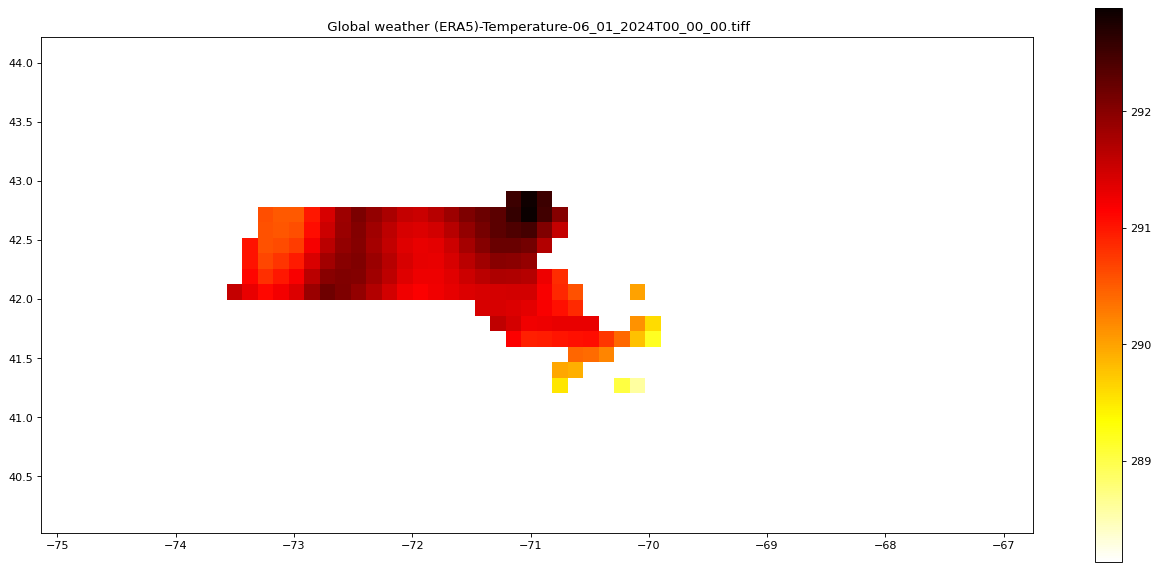

In [3]:
import json
import numpy as np
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

raster_result = raster.list_files()
for file in raster_result:
    if file.endswith('.tiff'):
        with open(file+'.json', 'r') as metadata_file:
            metadata = json.load(metadata_file)
        bbox=metadata["boundingBox"]
        extent=[bbox["minLongitude"],
                bbox["maxLongitude"],
                bbox["minLatitude"],
                bbox["maxLatitude" ]]  
        array_tiff = np.array(PIL.Image.open(file))
        plt.figure(figsize = (20, 9), dpi=80)
        vmin = metadata["rasterStatistics"]["pixelMin"]
        vmax = metadata["rasterStatistics"]["pixelMax"]
        plt.imshow(array_tiff,
                   cmap = 'hot_r', 
                   vmin=vmin, 
                   vmax=vmax,
                   extent = extent)
        plt.colorbar()
        plt.title(" " + os.path.basename(file))

## Multiple queries

The SDK contains an asynchronous worker for queries `ibmpairs.query.batch_query()`, see [Asynchronous Worker](asynchronous_worker.ipynb); due to this, the `ibmpairs.query.Query` objects `submit()`, `status()` and `download()` methods simply forward parameters to the `async_submit()`, `async_status()` and `async_download()` methods respectively.

The async feature can also be used within a [Jupyter Notebook](https://jupyter.org) where it hooks into the async loop that operates the notebook.

## Favorite

The `favorite` method on the `ibmpairs.query.Query` object, retains the result of the query beyond the default retention period of 90 days.

This means the query can be re-downloaded (using an id) beyond this limit.

To download a previously run query by the id number the function `ibmpairs.query.download(id = <id>)` can be used.